In [40]:
# raytracing tutorial
# 08- recursive raytracing with a simple scene

In [41]:
import numpy
import matplotlib.pyplot as plt
import math

# plot images in this notebook
%matplotlib inline

In [42]:
# axes x to the right, y upwards. z into the screen (left hand rule)

In [43]:
# sphere object

class Sphere():
    
    def __init__(self, x, y, z, r, colour):
        self.centre = numpy.array([x,y,z])
        self.radius = r
        self.colour = colour
        pass
    
    def status(self):
        print("centre = ", self.centre)
        print("radius = ", self.radius)
        print("colour = ", self.colour)
        pass

    def intersection(self, camera_location, ray_direction_vector):
        # calculate quadratic determinant "b^2 - 4ac" for ray intersecting circle
        b = numpy.dot(2 * ray_direction_vector,(camera_location - self.centre))
        b2 = b*b
        a = numpy.dot(ray_direction_vector, ray_direction_vector)
        c = numpy.dot((self.centre - camera_location), (self.centre - camera_location)) - (self.radius * self.radius)
        delta = b2 - (4 * a * c)
        #print(delta)
        
        if (delta >= 0):
            # calculate nearest point (lowest t)
            t = (-b - math.sqrt(delta)) / (2 * a)
            intersection_point = camera_location + (t * ray_direction_vector)
            
            # calculate normal at surface
            normal = (intersection_point - self.centre) / numpy.linalg.norm(intersection_point - self.centre)
            
            # additional check to ensure intersection was in direction of ray, t>0
            if (t<0):
                # set delta negative as if not intersected
                delta = -1
                pass
            
            # return tuple (intersection yes/no, nearest point, normal)
            return (delta>0, intersection_point, normal, self.colour)
            pass
        
        # return tuple (intersection yes/no, nearest point, norm, colour)
        return (delta >= 0, 0, 0, numpy.array([0,0,0]))

In [74]:
# camera location
camera_location = numpy.array([0,0,-100])

# view port
view_port_location = numpy.array([-10, 0, 0])
view_port_width = 20
view_port_height = 20

# resolution (pixels per unit distance)
resolution = 40

In [75]:
# light source

# light is at above right, and a bit forward
#light_location = numpy.array([100, 100, -50])
#light_location = numpy.array([0, 15, 50])
light_location = numpy.array([100, 100, -50])

# ambient light factor
ambient = 0.25

In [76]:
# scene is a list of objects
scene_objects = []

# add sphere
scene_objects.append(Sphere(0,10,10,5, numpy.array([1.0, 0.0, 0.0])))

# add another sphere
scene_objects.append(Sphere(0,20,20,3, numpy.array([0.0, 0.0, 1.0])))
scene_objects.append(Sphere(10,20,50,5, numpy.array([0.0, 1.0, 0.0])))
scene_objects.append(Sphere(-10,20,50,2, numpy.array([1.0, 1.0, 0.0])))

# get status of each object
for obj in scene_objects:
    obj.status()
    pass

centre =  [ 0 10 10]
radius =  5
colour =  [ 1.  0.  0.]
centre =  [ 0 20 20]
radius =  3
colour =  [ 0.  0.  1.]
centre =  [10 20 50]
radius =  5
colour =  [ 0.  1.  0.]
centre =  [-10  20  50]
radius =  2
colour =  [ 1.  1.  0.]


In [77]:
# create image

image = numpy.zeros([view_port_width * resolution, view_port_height * resolution, 3], dtype='float64')
print("image shape = ", image.shape)

image shape =  (800, 800, 3)


In [78]:
# max ray tracing depth for scene
max_depth = 2

# recursive ray function
def ray(ray_origin, ray_direction, depth):
    
    # start with zero colour contribution, false intersected flag and nearest point at infinity
    colour_contribution = numpy.array([0.0,0.0,0.0])    
    intersected = False
    distance_to_nearest_point = numpy.Infinity
    
    for obj in scene_objects:
        
        # check intersection with object
        intersection = obj.intersection(ray_origin, ray_direction)
        
        # did it intersect?
        if intersection[0]:
            intersected = True
            
            distance_to_point = numpy.linalg.norm(intersection[1] - ray_origin)
            
            if (distance_to_point < distance_to_nearest_point):
                
                # update nearest point
                distance_to_nearest_point = distance_to_point
                point_on_nearest_obj = intersection[1]
                norm = intersection[2]
                obj_colour = intersection[3]
                
                # vector to light
                to_light = light_location - point_on_nearest_obj
                to_light /= numpy.linalg.norm(to_light)
                
                # illumination factor
                cos_norm_to_lightsource = numpy.dot(to_light, norm) / numpy.linalg.norm(to_light)
                
                # reflected factor (will have norm 1)
                reflected_ray = (2 * numpy.dot(norm, to_light) * norm) - to_light
                cos_ray_to_reflection = numpy.dot(-ray_direction, reflected_ray) / (numpy.linalg.norm(reflected_ray))
            
                # clip if below zero
                cos_norm_to_lightsource = numpy.clip(cos_norm_to_lightsource, 0, 1)
                cos_ray_to_reflection = numpy.clip(cos_ray_to_reflection, 0, 1)
                
                # apply power
                cos_norm_to_lightsource = math.pow(cos_norm_to_lightsource, 2)
                cos_ray_to_reflection = math.pow(cos_ray_to_reflection, 2)
                
                # candidate colour contribution
                candidate_colour_contribution = (obj_colour * cos_norm_to_lightsource * cos_ray_to_reflection)
                pass
            
            pass
        
        #next object
        pass
    
    # fire off new ray if intersected and depth is within max
    if (intersected):
        
        # colour contribution from nearest object
        colour_contribution = candidate_colour_contribution
        # add ambient light, diminish with depth
        colour_contribution += obj_colour * ambient / (depth)
        
        # recurse colour contribution from bounced ray
        if (depth < max_depth):
            # bounced ray (from source, not from light source)
            bounced_ray = (2 * numpy.dot(norm, -ray_direction) * norm) + ray_direction
            # divide by depth to reduce strength of light after many reflections
            colour_contribution += (ray(point_on_nearest_obj, bounced_ray, depth + 1)[1] / (0.5 * depth))
            pass
        
        pass
    
    return intersected, colour_contribution

In [79]:
# main loop is to consider every pixel of the viewport

for pixel_ix in range(image.shape[0]):
    for pixel_iy in range(image.shape[1]):
#for pixel_ix in range(400,401):
#    for pixel_iy in range(280,281):


        # ray direction
        current_position = view_port_location + numpy.array([pixel_ix/resolution, pixel_iy/resolution, 0])
        ray_direction = current_position - camera_location
        ray_direction /= numpy.linalg.norm(ray_direction)
        
        # pixel is set to colour contribution from (recursive) ray
        intersected, colour_contribution = ray(camera_location, ray_direction, 1)
        if (intersected):
            image[pixel_ix, pixel_iy] = colour_contribution
        else:
            image[pixel_ix, pixel_iy] = [0.3 + ray_direction[1], 0.3 + ray_direction[1], 0.6 + (ray_direction[1] * 5)]
            pass
        
        pass
    pass

In [80]:
# apply squashing function to image
# first shift data into range [0,1] asymptotically
# then remap to colour RGB range [0,255] dtype=uint8

# squash with tanh()
image = numpy.tanh(image)

# remap to RGB range
image_rgb = numpy.array(image*255, dtype='uint8')

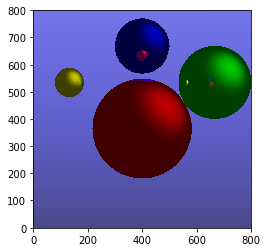

In [81]:
# transpose array so origin is bottom left, by swapping dimensions 0 and 1, but leave dimension 3

image_rgb2 = numpy.transpose(image_rgb, (1, 0, 2))
plt.imshow(image_rgb2, origin='lower')

In [82]:
plt.imsave('test.png', image_rgb2, origin='lower')